In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [153]:
class CountingProcess:
    def __init__(self, T, process_name="Counting process"):
        self.T = T
        self.name = process_name
        self.events = self.generate_events()
        self.N = len(self.events)
        self.res = 1000

    def generate_events(self):
        raise NotImplementedError("The method 'generate_events' must be implemented in a subclass")

    def generate_intensity(self):
        raise NotImplementedError("The method 'generate_intensity' must be implemented in a subclass")

    def get_mean_and_variance(self, t):
        raise NotImplementedError("The method 'get_mean_and_variance' must be implemented in a subclass")

    def get_mean_and_variance_of_intensity(self, t):
        raise NotImplementedError("The method 'get_mean_and_variance_of_intensity' must be implemented in a subclass")

    def _events_with_limits(self):
        return [0] + self.events + [self.T]

    def _process_on_ax(self, ax, plot_theory=False):
        ax.step(self._events_with_limits(), list(range(self.N + 1)) + [self.N], where="post")
        if plot_theory:
            x = np.linspace(0, self.T, self.res)
            mean, var = self.get_mean_and_variance(x)
            ax.plot(x, mean, color="green")
            ax.fill_between(x, mean - 1.96*np.sqrt(var), mean + 1.96*np.sqrt(var), color="green", alpha=0.1)
        ax.vlines(self.events, *ax.get_ylim(), color="red", linewidth=0.5, linestyle="dashed")
        ax.set_xlim(0, self.T)
        ax.set_title(self.name)
        ax.set_xlabel("Time")
        ax.set_ylabel("$N(t)$")
        ax.grid()

    def _intensity_on_ax(self, ax, plot_theory=False):
        absintens, intens = self.generate_intensity()
        ax.plot(absintens, intens)
        if plot_theory:
            mean, var = self.get_mean_and_variance_of_intensity(absintens)
            ax.plot(absintens, mean, color="green")
            ax.fill_between(absintens, mean - 1.96*np.sqrt(var), mean + 1.96*np.sqrt(var), color="green", alpha=0.2)
        ax.vlines(self.events, *ax.get_ylim(), color="red", linewidth=0.5, linestyle="dashed")
        ax.set_xlim(0, self.T)
        ax.set_title(self.name + " intensity")
        ax.set_xlabel("Time")
        ax.set_ylabel("$\lambda(t)$")
        ax.grid()

    def plot_process(self, plot_theory=False, dim=(6,10)):
        fig, ax = plt.figure(figsize=dim)
        self._process_on_ax(ax)
        plt.show()

    def plot_intensity(self, plot_theory=False, dim=(6,10)):
        fig, ax = plt.figure(figsize=dim)
        self._intensity_on_ax(ax)
        plt.show()

    def plot_process_and_intensity(self, plot_theory=False, dim=(10,8)):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=dim)
        self._process_on_ax(ax1, plot_theory=plot_theory)
        self._intensity_on_ax(ax2, plot_theory=plot_theory)
        fig.tight_layout()
        plt.show()

<ipython-input-153-bb62672230b6>:44: RuntimeWarning: invalid value encountered in sqrt
  ax.fill_between(absintens, mean - 1.96*np.sqrt(var), mean + 1.96*np.sqrt(var), color="green", alpha=0.2)


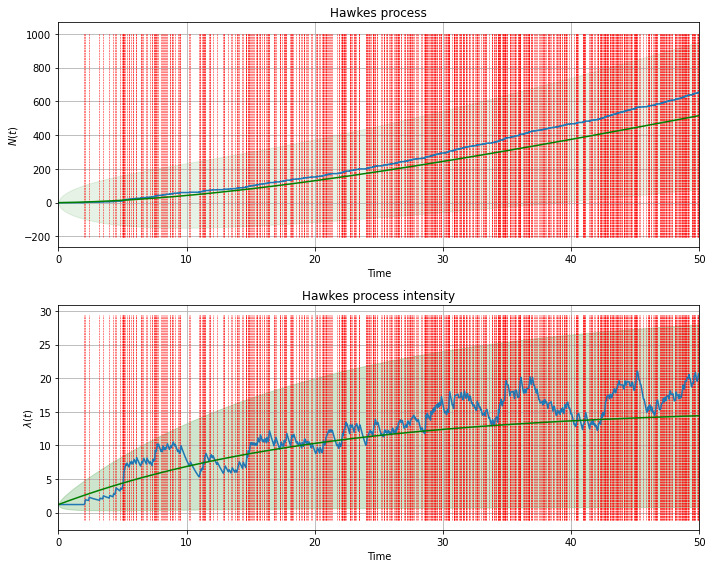

In [154]:
class HawkesProcess(CountingProcess):
    def __init__(self, mu, alpha, beta, T, name="Hawkes process"):
        if alpha <  0 or beta < alpha:
            raise ValueError(f"We must have 0 < alpha < beta (alpha={alpha} and beta={beta})")
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        super().__init__(T, name)

    def phi(self, t):
        return self.alpha * np.exp(-self.beta * t)

    def lamb(self, t, tau):
        return self.mu + sum([self.phi(t-tk) for tk in tau])

    def generate_events(self):
        Tau = []
        s = n = 0
        while s < self.T:
            lambda_bar = self.lamb(s, Tau)
            u = np.random.uniform(0,1)
            w = -np.log(u)/lambda_bar
            s += w
            D = np.random.uniform(0,1)
            if D*lambda_bar <= self.lamb(s, Tau):
                n += 1
                t = s
                Tau.append(t)
        if t <= self.T:
            return Tau
        else:
            return Tau[:-1]

    def generate_intensity(self):
        x = np.linspace(0, self.T, self.res)
        intensity = self.mu * np.ones(self.res)
        points0 = self._events_with_limits()
        for i in range(len(points0)-1):
            p1, p2 = points0[i:i+2]
            i1 = (np.abs(x - p1)).argmin() + 1  # +1 for left continuity
            i2 = (np.abs(x - p2)).argmin() + 1  # +1 because of python range excluding last element
            if i == 0:
                intensity[i1:i2] = self.mu
            else:
                local_intensity = np.array([self.lamb(x[ii], points0[:i]) for ii in range(i1, i2)])
                intensity[i1:i2] = local_intensity
        return x, intensity

    def get_mean_and_variance(self, t):
        diff = self.beta - self.alpha
        mu_inf = self.beta*self.mu/diff
        mean = mu_inf*t + (self.mu - mu_inf)/diff * (1 - np.exp(-diff*t))
        var = self.beta**2*mu_inf/diff**2*t + \
              self.alpha**2*(2*self.mu - mu_inf)/(2*diff)**3 * (1 - np.exp(-2*diff*t)) - \
              2*self.alpha*self.beta*(self.mu - mu_inf)/diff**2 * t * np.exp(-diff*t) + \
              ( (self.beta+self.alpha)/diff**2 * (self.mu-mu_inf) - 2*self.alpha*self.beta/diff**3 * mu_inf) * (1 - np.exp(-diff*t))
        return mean, var

    def get_mean_and_variance_of_intensity(self, t):
        diff = self.beta - self.alpha
        mu_inf = self.beta*self.mu/diff
        mean = mu_inf + (self.mu - mu_inf) * np.exp(-diff*t)
        var = self.alpha**2*mu_inf/(2*diff) + self.alpha**2*(self.mu-mu_inf)/diff*np.exp(-diff*t) - self.alpha**2*(2*self.mu-mu_inf)/(2*diff)*np.exp(-2*diff*t)
        return mean, var

h = HawkesProcess(1.2, 0.6, .65, 50)
h.plot_process_and_intensity(plot_theory=True)

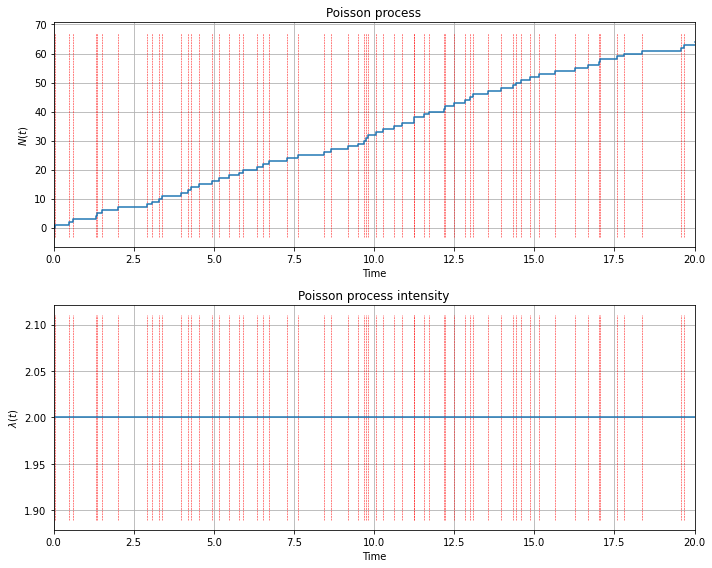

In [148]:
class PoissonProcess(CountingProcess):
    def __init__(self, lamb, T, name="Poisson process"):
        if lamb <= 0:
            raise ValueError(f"lambda must be strictly positive (lambda={lamb})")
        self.lamb = lamb
        super().__init__(T, name)

    def generate_events(self):
        Tau = []
        s = 0
        while s < self.T:
            u = np.random.uniform(0,1)
            w = -np.log(u)/self.lamb
            s += w
            Tau.append(s)
        return Tau

    def generate_intensity(self):
        x = [0, self.T]
        intensity = [self.lamb, self.lamb]
        return x, intensity

p = PoissonProcess(2, 20)
p.plot_process_and_intensity()